In [10]:
# Notebook 2: PF03060 Evaluation vs Pfam (SwissProt)
# --------------------------------------------------


import os, json, math, time, random
from pathlib import Path
import numpy as np
import pandas as pd
import requests
from io import StringIO

PFAM_ID = "PF03060"
OUTPUT_DIR = "data"
RESULTS_DIR = "results"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

PSSM_CSV = f"{RESULTS_DIR}/PF03060_PSSM_logodds.csv"
HMM_JSON = f"{RESULTS_DIR}/PF03060_profileHMM.json"

pssm_df = pd.read_csv(PSSM_CSV)
with open(HMM_JSON) as f:
    hmm = json.load(f)

print("Loaded PSSM:", PSSM_CSV, "| length =", len(pssm_df))
print("Loaded HMM:", HMM_JSON, "| length =", hmm["length"])

Loaded PSSM: results/PF03060_PSSM_logodds.csv | length = 350
Loaded HMM: results/PF03060_profileHMM.json | length = 350


In [11]:
# Build a fast PSSM scorer (sliding window)

AA = list("ACDEFGHIKLMNPQRSTVWY")
aa_to_idx = {a:i for i,a in enumerate(AA)}

# PSSM matrix: L x 20
L = len(pssm_df)
pssm_mat = np.zeros((L, len(AA)), dtype=float)
for i, a in enumerate(AA):
    pssm_mat[:, i] = pssm_df[a].values

def best_pssm_score(protein_seq: str) -> tuple:
    """
    Returns (best_score, best_start_index_0based)
    Sliding window of length L.
    Non-AA chars break scoring (window skipped).
    """
    s = protein_seq
    n = len(s)
    if n < L:
        return (float("-inf"), None)

    best = float("-inf")
    best_i = None

    # pre-map sequence to indices (-1 for bad)
    idx = np.fromiter((aa_to_idx.get(ch, -1) for ch in s), dtype=int, count=n)

    for i in range(0, n - L + 1):
        window = idx[i:i+L]
        if (window < 0).any():
            continue
        score = pssm_mat[np.arange(L), window].sum()
        if score > best:
            best = score
            best_i = i
    return best, best_i

In [12]:
#Lightweight HMM scorer (same windowing, adds match-fraction penalty)

# Precompute HMM log emissions (L x 20) and background log probs

bg = hmm["background"]
emissions = hmm["emissions"]  # list of dicts length L
match_frac = hmm["match_fraction"]

hmm_log_emit = np.zeros((L, len(AA)), dtype=float)
bg_log = np.zeros(len(AA), dtype=float)
match_log = np.array([math.log(max(m, 1e-12)) for m in match_frac], dtype=float)

for j, a in enumerate(AA):
    bg_log[j] = math.log(max(bg[a], 1e-12))

for i in range(L):
    for j, a in enumerate(AA):
        hmm_log_emit[i, j] = math.log(max(emissions[i][a], 1e-12)) - bg_log[j]  # log-odds

def best_hmm_score(protein_seq: str) -> tuple:
    """
    Returns (best_score, best_start_index_0based)
    Score = sum_i log-odds(emission) + sum_i log(match_fraction_i)
    """
    s = protein_seq
    n = len(s)
    if n < L:
        return (float("-inf"), None)

    best = float("-inf")
    best_i = None

    idx = np.fromiter((aa_to_idx.get(ch, -1) for ch in s), dtype=int, count=n)

    base_match_penalty = match_log.sum()

    for i in range(0, n - L + 1):
        window = idx[i:i+L]
        if (window < 0).any():
            continue
        score = hmm_log_emit[np.arange(L), window].sum() + base_match_penalty
        if score > best:
            best = score
            best_i = i
    return best, best_i

In [13]:
UNIPROT_SEARCH = "https://rest.uniprot.org/uniprotkb/search"

def fetch_uniprot_reviewed_pfam(pfam_id: str, size=500, cursor=None):
    query = f'reviewed:true AND (xref:pfam-{pfam_id})'
    params = {
        "query": query,
        "format": "tsv",
        "fields": "accession,sequence",
        "size": size
    }
    if cursor:
        params["cursor"] = cursor

    r = requests.get(UNIPROT_SEARCH, params=params, timeout=(15, 180))
    r.raise_for_status()
    df = pd.read_csv(StringIO(r.text), sep="\t")
    # get next cursor from headers if present
    next_cursor = r.headers.get("x-next-cursor")
    return df, next_cursor

# Cache positives
POS_TSV = f"{OUTPUT_DIR}/swissprot_pos_{PFAM_ID}.tsv"

if os.path.exists(POS_TSV) and os.path.getsize(POS_TSV) > 0:
    pos_df = pd.read_csv(POS_TSV, sep="\t")
    print("Loaded cached positives:", len(pos_df))
else:
    all_parts = []
    cursor = None
    while True:
        df, cursor = fetch_uniprot_reviewed_pfam(PFAM_ID, size=500, cursor=cursor)
        if df.empty:
            break
        all_parts.append(df)
        print("Fetched positives so far:", sum(len(x) for x in all_parts))
        if not cursor:
            break
    pos_df = pd.concat(all_parts, ignore_index=True)
    pos_df.to_csv(POS_TSV, sep="\t", index=False)
    print("Saved positives:", POS_TSV, "| n =", len(pos_df))

pos_df.head()

Loaded cached positives: 27


,Entry,Sequence
0,Q9I4V0,MGVFRTRFTETFGVEHPIMQGGMQWVGRAEMAAAVANAGGLATLSA...
1,Q01284,MHFPGHSSKKEESAQAALTKLNSWFPTTKNPVIISAPMYLIANGTL...
2,Q9HWH9,MTDRFTRLLGIQQPIIQAPMLGVSTPALAAAVSNAGGLGSIAITGS...
3,O34787,MITYVFPGQGSQQKGMGQGLFEQYQHLTDQADQILGYSIEKLCTEK...
4,P47177,MYFLNQLIFQDVSVMSVDKREDMSRSFQKCLNLRYPIIQAPMAGVT...


This gives you protein-level ground truth positives.
(Residue-level ground truth using coordinates is doable too, but we can add that after your protein-level evaluation is working.)

In [14]:
# Build a SwissProt negative set
# sample reviewed SwissProt proteins that do NOT have PF03060.

def fetch_uniprot_reviewed_negatives(pfam_id: str, n=2000, batch=500):
    query = f"reviewed:true AND NOT (xref:pfam-{pfam_id})"
    got = []
    cursor = None
    while len(got) < n:
        params = {
            "query": query,
            "format": "tsv",
            "fields": "accession,sequence",
            "size": batch
        }
        if cursor:
            params["cursor"] = cursor
        r = requests.get(UNIPROT_SEARCH, params=params, timeout=(15, 180))
        r.raise_for_status()
        df = pd.read_csv(StringIO(r.text), sep="\t")
        if df.empty:
            break
        got.append(df)
        cursor = r.headers.get("x-next-cursor")
        if not cursor:
            break
    out = pd.concat(got, ignore_index=True).head(n)
    return out

NEG_TSV = f"{OUTPUT_DIR}/swissprot_neg_{PFAM_ID}.tsv"
NEG_N = max(2000, len(pos_df))  # at least as many negatives as positives

if os.path.exists(NEG_TSV) and os.path.getsize(NEG_TSV) > 0:
    neg_df = pd.read_csv(NEG_TSV, sep="\t")
    print("Loaded cached negatives:", len(neg_df))
else:
    neg_df = fetch_uniprot_reviewed_negatives(PFAM_ID, n=NEG_N, batch=500)
    neg_df.to_csv(NEG_TSV, sep="\t", index=False)
    print("Saved negatives:", NEG_TSV, "| n =", len(neg_df))

neg_df.head()


Loaded cached negatives: 500


,Entry,Sequence
0,A0A0C5B5G6,MRWQEMGYIFYPRKLR
1,A0A1B0GTW7,MLLLLLLLLLLPPLVLRVAASRCLHDETQKSVSLLRPPFSQLPSKS...
2,A0JNW5,MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVL...
3,A0JP26,MVAEVCSMPAASAVKKPFDLRSKMGKWCHHRFPCCRGSGKSNMGTS...
4,A0PK11,MPGWFKKAWYGLASLLSFSSFILIIVALVVPHWLSGKILCQTGVDL...


In [17]:
# scores

def score_df(df: pd.DataFrame, scorer_fn):
    scores = []
    starts = []
    too_short = 0

    for _, row in df.iterrows():
        seq = row["Sequence"]
        sc, st = scorer_fn(seq)

        # If scorer returned -inf (too short or no valid window)
        if sc is None or (isinstance(sc, float) and not np.isfinite(sc)):
            scores.append(np.nan)   # mark as NaN instead of -inf
            starts.append(None)
            too_short += 1
        else:
            scores.append(sc)
            starts.append(st)

    print(f"{too_short} proteins could not be scored (too short or invalid).")
    return np.array(scores, dtype=float), np.array(starts, dtype=object)


# Score datasets
pos_pssm, _ = score_df(pos_df, best_pssm_score)
neg_pssm, _ = score_df(neg_df, best_pssm_score)

pos_hmm, _ = score_df(pos_df, best_hmm_score)
neg_hmm, _ = score_df(neg_df, best_hmm_score)


# Compute means ignoring NaNs
print("PSSM scores:",
      "pos mean", np.nanmean(pos_pssm),
      "neg mean", np.nanmean(neg_pssm))

print("HMM  scores:",
      "pos mean", np.nanmean(pos_hmm),
      "neg mean", np.nanmean(neg_hmm))

3 proteins could not be scored (too short or invalid).
202 proteins could not be scored (too short or invalid).
3 proteins could not be scored (too short or invalid).
202 proteins could not be scored (too short or invalid).
PSSM scores: pos mean -79.99063550566736 neg mean -240.39820877760545
HMM  scores: pos mean -106.05180852306644 neg mean -266.4593817950045


In [18]:
# Choose thresholds + compute metrics

def metrics_at_threshold(pos_scores, neg_scores, thr):
    TP = int((pos_scores >= thr).sum())
    FN = int((pos_scores <  thr).sum())
    FP = int((neg_scores >= thr).sum())
    TN = int((neg_scores <  thr).sum())

    precision = TP / (TP + FP) if (TP + FP) else 0.0
    recall    = TP / (TP + FN) if (TP + FN) else 0.0
    f1 = (2*precision*recall/(precision+recall)) if (precision+recall) else 0.0

    denom = math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    mcc = ((TP*TN - FP*FN)/denom) if denom else 0.0

    return {"thr": thr, "TP":TP, "FP":FP, "TN":TN, "FN":FN,
            "precision":precision, "recall":recall, "F1":f1, "MCC":mcc}

def find_best_threshold(pos_scores, neg_scores):
    candidates = np.unique(np.concatenate([pos_scores, neg_scores]))
    # sample candidates if too many
    if len(candidates) > 2000:
        candidates = np.quantile(candidates, np.linspace(0,1,2000))
    best = None
    for thr in candidates:
        m = metrics_at_threshold(pos_scores, neg_scores, thr)
        if (best is None) or (m["F1"] > best["F1"]):
            best = m
    return best

best_pssm = find_best_threshold(pos_pssm, neg_pssm)
best_hmm  = find_best_threshold(pos_hmm,  neg_hmm)

pd.DataFrame([{"model":"PSSM", **best_pssm}, {"model":"HMM", **best_hmm}])

,model,thr,TP,FP,TN,FN,precision,recall,F1,MCC
0,PSSM,-202.665566,20,2,296,4,0.909091,0.833333,0.869565,0.860496
1,HMM,-228.726739,20,2,296,4,0.909091,0.833333,0.869565,0.860496


In [19]:
# Save scored datasets for reproducibility
EVAL_OUT = f"{RESULTS_DIR}/PF03060_eval_scores.csv"

eval_pos = pos_df.copy()
eval_pos["label"] = 1
eval_pos["pssm_score"] = pos_pssm
eval_pos["hmm_score"] = pos_hmm

eval_neg = neg_df.copy()
eval_neg["label"] = 0
eval_neg["pssm_score"] = neg_pssm
eval_neg["hmm_score"] = neg_hmm

eval_all = pd.concat([eval_pos, eval_neg], ignore_index=True)
eval_all.to_csv(EVAL_OUT, index=False)
print("Saved:", EVAL_OUT, "| rows:", len(eval_all))

Saved: results/PF03060_eval_scores.csv | rows: 527


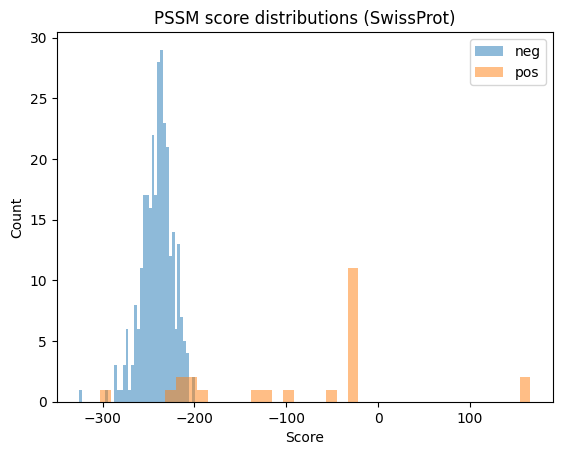

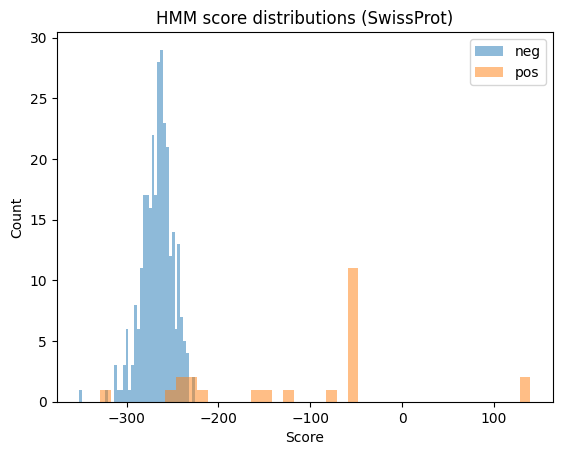

In [20]:
import matplotlib.pyplot as plt

def plot_hist(pos_scores, neg_scores, title):
    pos_scores = pos_scores[np.isfinite(pos_scores)]
    neg_scores = neg_scores[np.isfinite(neg_scores)]

    plt.figure()
    plt.hist(neg_scores, bins=40, alpha=0.5, label="neg")
    plt.hist(pos_scores, bins=40, alpha=0.5, label="pos")
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.title(title)
    plt.legend()
    plt.show()

plot_hist(pos_pssm, neg_pssm, "PSSM score distributions (SwissProt)")
plot_hist(pos_hmm,  neg_hmm,  "HMM score distributions (SwissProt)")